<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/quest_02_The_Model_Path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model


# Quest 02 - Explore data and models
## Neural Networks for Images

__2. The model path__

Take a well-trained model, image classification works best here. Keras applications (tf.keras.applications) and the vision model zoo are great starting points. Investigate and implement the following simple but powerful interpretability techniques. Optionally, you can perform all of following things to a model you've trained yourself but I expect the results will be unstable / worse.

+ Inspect the weights in at least one conv layer. Research how to visualize the kernels themselves. This is commonly done only for the first conv layer.
+ Take the final conv output vectors and show a tSNE embedding of them. For better visualization, you'll need to see the actual images. You can take some inspiration from activation atlases: https://distill.pub/2019/activation-atlas/
+ Pick a specific kernel. Pass "a few", e.g. 200-300, images through the NN, record the kernel activations (feature maps) and see which images activate it maximally. To compare activations, I suggest using a norm, e.g. Euclidean. Then pick several more kernels and do the same. You should see a pattern.
+ To take this a step further, you could "teach" (optimize) an image which activates your kernel maximally. Look at the first section of this notebook: https://distill.pub/2017/feature-visualization/. If you have time, look at the entire thing; it's awesome.

+ There are also methods which use gradient ascent for this, but their results are almost never any good visually.
+ Look at saliency maps. This paper: https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53 has A LOT to show. The simplest way I've seen is to hide (occlude) a part of the image and see how much the model performance drops. This is the same idea as permutation feature importances in ML. This technique is also really powerful in detecting biases and has helped me many, many times over the years. Pass a few images, and produce saliency maps.
+ You can also look at GradCAM (gradient-weighted class activation mapping): https://arxiv.org/abs/1610.02391
+ To visualize intermediate images, ZFNet (paper & code here: https://paperswithcode.com/method/zfnet) is also very useful. It uses a small decoder NN to  "reverse" the encoding of a conv layer.

### Resnet50

A well trained modell - Resnet50:

In [2]:
resnet = ResNet50(include_top = True, weights = "imagenet", classifier_activation = "softmax")

In [3]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

### Imagenette

And a "few" images to play around with - Imagenette - a small subset of Imagenet - 10 easy classes. Labels from https://github.com/fastai/imagenette

In [4]:
imagenette, info = tfds.load("imagenette/160px-v2", split = "validation", with_info = True)

In [5]:
# info

In [6]:
imagenette.cardinality()


<tf.Tensor: shape=(), dtype=int64, numpy=3925>

In [7]:
labels = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
labels_dict = {i: label for i, label in enumerate(labels)}
labels_dict

{0: 'tench',
 1: 'English springer',
 2: 'cassette player',
 3: 'chain saw',
 4: 'church',
 5: 'French horn',
 6: 'garbage truck',
 7: 'gas pump',
 8: 'golf ball',
 9: 'parachute'}

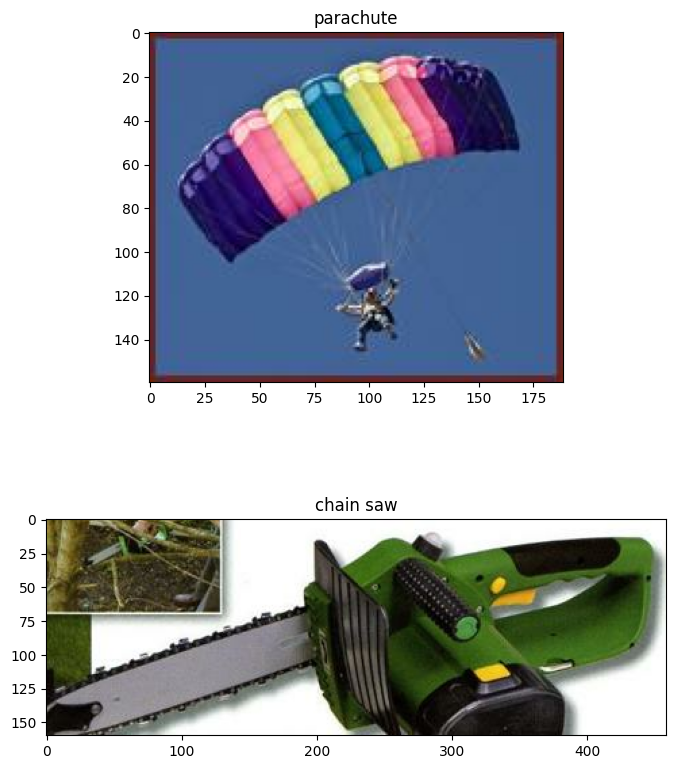

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

for i, el in enumerate(imagenette.take(2)):

    axs[i].imshow(el["image"])
    axs[i].set_title(labels_dict[(el["label"].numpy())])

plt.show()

### Map imagenette labels to imagenet labels

imagenet labels from https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [9]:
imagenet_labels = \
"""0 tench
217 English_springer
482 cassette_player
491 chain_saw
497 church
566 French_horn
569 garbage_truck
571 gas_pump
574 golf_ball
701 parachute"""

In [10]:
imagenet_labels = [row.split(" ") for row in imagenet_labels.split("\n")]
labels_imagenet_dict = {int(row[0]):row[1].replace("_", " ") for row in imagenet_labels}
labels_imagenet_dict

{0: 'tench',
 217: 'English springer',
 482: 'cassette player',
 491: 'chain saw',
 497: 'church',
 566: 'French horn',
 569: 'garbage truck',
 571: 'gas pump',
 574: 'golf ball',
 701: 'parachute'}

In [11]:
labels_imagenet_dict_rev = {v:k for k, v in labels_imagenet_dict.items()}
labels_imagenet_dict_rev

{'tench': 0,
 'English springer': 217,
 'cassette player': 482,
 'chain saw': 491,
 'church': 497,
 'French horn': 566,
 'garbage truck': 569,
 'gas pump': 571,
 'golf ball': 574,
 'parachute': 701}

In [12]:
imagenette_to_imagenet_labels = {k: labels_imagenet_dict_rev[v] for k, v in labels_dict.items()}
imagenette_to_imagenet_labels

{0: 0, 1: 217, 2: 482, 3: 491, 4: 497, 5: 566, 6: 569, 7: 571, 8: 574, 9: 701}

In [13]:
# @tf.py_function(Tout=tf.int64) # nope
# def map_label(label):
#   return imagenette_to_imagenet_labels[label.numpy()]

# # ValueError: as_list() is not defined on an unknown TensorShape.

In [14]:
list(imagenette_to_imagenet_labels.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
labels_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(imagenette_to_imagenet_labels.keys()), dtype=tf.int64),
        values=tf.constant(list(imagenette_to_imagenet_labels.values()),  dtype=tf.int64),
    ),
    default_value= tf.constant(-1,  dtype=tf.int64)
)


In [16]:
labels_table[tf.constant([4], dtype=tf.int64)]

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([497])>

### Image preprocess

In [17]:
def preprocess_image(img):
  img = tf.image.resize(img, size = (224, 224))
  img = preprocess_input(img)

  return img

In [18]:
imagenette_preprocessed = imagenette.map(lambda x: (
    preprocess_image(x["image"]),
    labels_table[x["label"]]
    ))

In [19]:
for image, label in imagenette_preprocessed.batch(1).take(5):
  predictions = resnet.predict(image)
  print(decode_predictions(predictions, top = 1))
  print(tf.argmax(predictions, axis=-1), label)


1/1 [==============================] - 4s 4s/step
[[('n03888257', 'parachute', 0.9998116)]]
tf.Tensor([701], shape=(1,), dtype=int64) tf.Tensor([701], shape=(1,), dtype=int64)
1/1 [==============================] - 0s 391ms/step
[[('n03000684', 'chain_saw', 0.99897325)]]
tf.Tensor([491], shape=(1,), dtype=int64) tf.Tensor([491], shape=(1,), dtype=int64)
1/1 [==============================] - 0s 382ms/step
[[('n02979186', 'cassette_player', 0.5812742)]]
tf.Tensor([482], shape=(1,), dtype=int64) tf.Tensor([482], shape=(1,), dtype=int64)
1/1 [==============================] - 0s 318ms/step
[[('n02102040', 'English_springer', 0.8813532)]]
tf.Tensor([217], shape=(1,), dtype=int64) tf.Tensor([217], shape=(1,), dtype=int64)
1/1 [==============================] - 0s 329ms/step
[[('n09288635', 'geyser', 0.101408355)]]
tf.Tensor([974], shape=(1,), dtype=int64) tf.Tensor([701], shape=(1,), dtype=int64)


### Evaluate Resnet on Imagenette

In [20]:
resnet.compile(metrics = "accuracy")

In [21]:
resnet.evaluate(imagenette_preprocessed.batch(16).take(4))

4/4 [==============================] - 12s 2s/step - loss: 0.0000e+00 - accuracy: 0.6875


[0.0, 0.6875]

#### Inspect the weights in at least one conv layer. Research how to visualize the kernels themselves. This is commonly done only for the first conv layer.

In [22]:
for layer in resnet.layers[:5]:
  print(layer)

In [23]:
first_conv = resnet.layers[2]
first_conv.name, first_conv

('conv1_conv',
 <keras.src.layers.convolutional.conv2d.Conv2D at 0x7948cb8718a0>)

In [24]:
kernel_conv1, bias_conv_1 = first_conv.weights

In [25]:
kernel_conv1.shape, bias_conv_1.shape

(TensorShape([7, 7, 3, 64]), TensorShape([64]))

In [26]:
kernel_conv1.numpy().min(), kernel_conv1.numpy().max()

(-0.6710244, 0.70432377)

In [27]:
weights_kernel_flat = kernel_conv1.numpy().flatten()

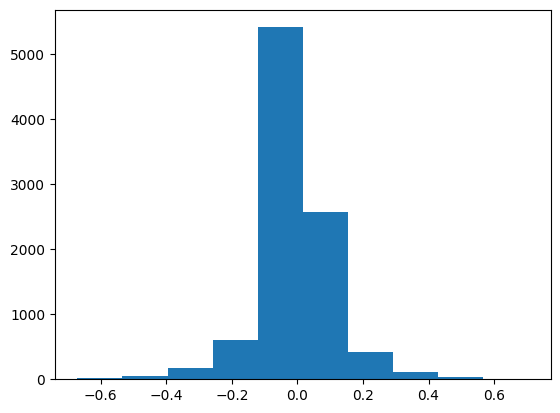

In [28]:
plt.hist(weights_kernel_flat)
plt.show()

Visualise kernels of first 10 filter of the first conv layer, each channel a separate implot

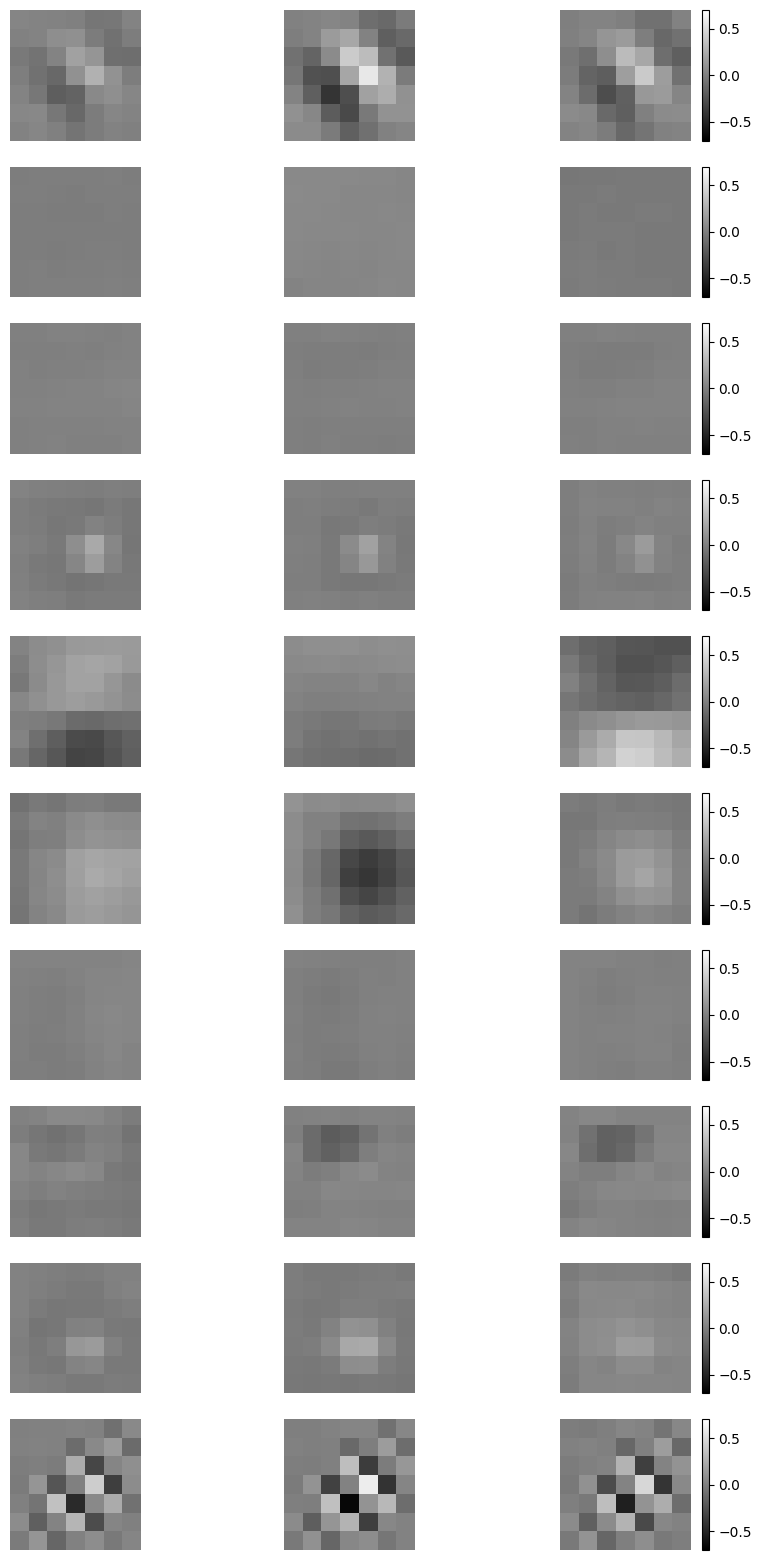

In [29]:
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

for filter in range(10):
  for channel in range(3):
    image = axs[filter, channel].imshow(kernel_conv1[:,:, channel, filter], vmin = -0.7, vmax = 0.7, cmap = "gray")
    axs[filter, channel].axis("off")

  fig.colorbar(image, ax=axs[filter, 2])

plt.show()

Next filters 10 to 19:

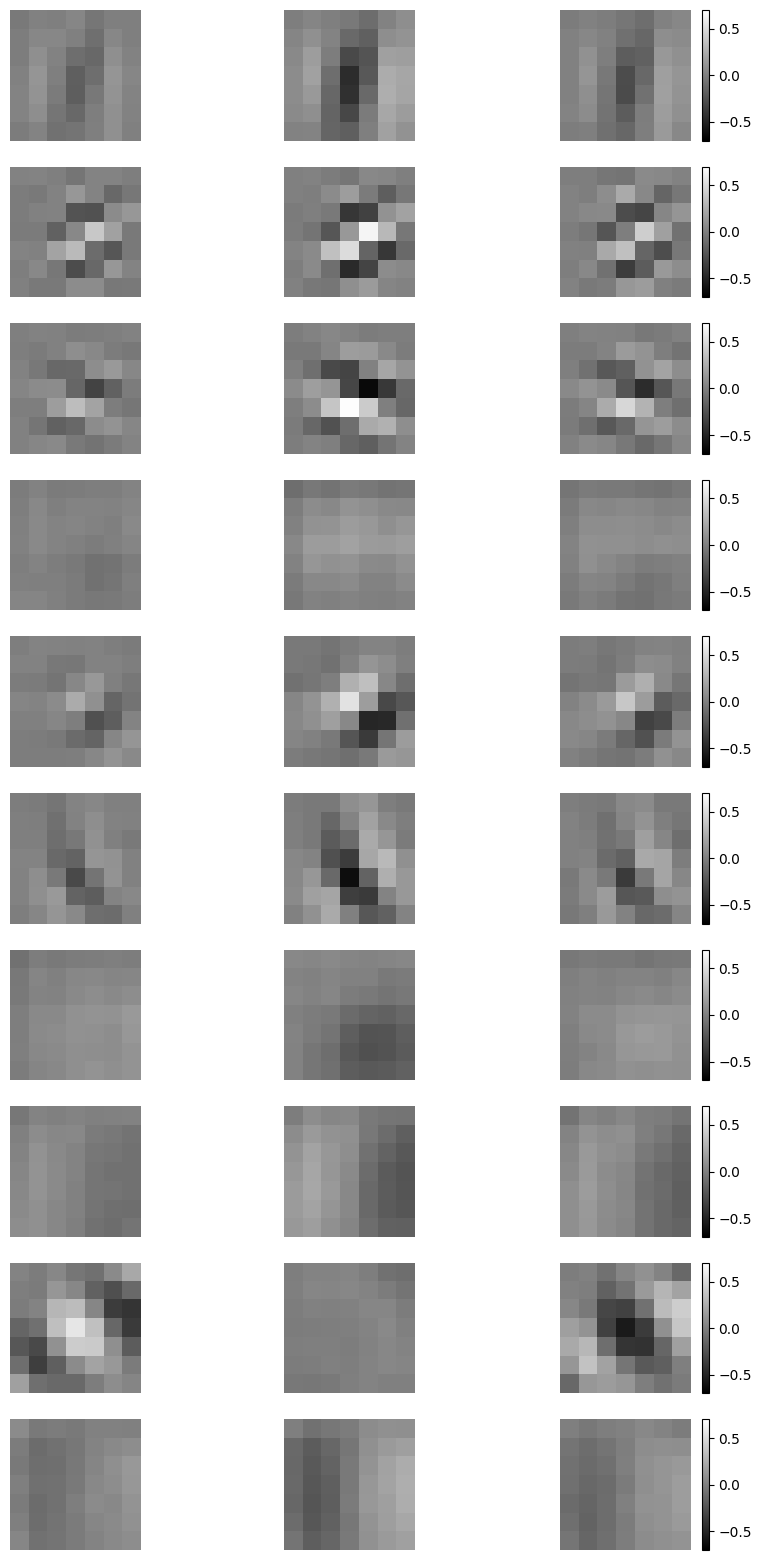

In [30]:
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

for filter in range(10):
  for channel in range(3):
    image = axs[filter, channel].imshow(kernel_conv1[:,:, channel, filter + 10], vmin = -0.7, vmax = 0.7, cmap = "gray")
    axs[filter, channel].axis("off")

  fig.colorbar(image, ax=axs[filter, 2])

plt.show()

Take the final conv output vectors and show a tSNE embedding of them. For better visualization, you'll need to see the actual images.

In [33]:
for layer in resnet.layers[-8:]:
  print(layer)

In [34]:
final_conv_output = resnet.layers[-6].output
final_conv_output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_3_conv')>

In [35]:
final_conv_output_model = Model(inputs = resnet.inputs, outputs = final_conv_output)

In [43]:
for image, label in imagenette_preprocessed.batch(1).take(1):

    print(final_conv_output_model(image).shape)

(1, 7, 7, 2048)
